# Install Libraries

In [ ]:
!pip3 install -r requirements.txt

  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-74zdsweu
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-74zdsweu
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit beb9f7d70d20aa326de005d6f4e4cc6026d1c539
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=504020 sha256=d659486efbc6223cf04c652423809e3cfac4b48e81737bd4

# Import Libraries

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp

import models
import parameters
import utils

# Device Preparation

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Unzip Dataset

In [ ]:
!unzip dataset.zip

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


# Import Dataset

In [ ]:
#df = pd.read_csv("dataset/preprocessed_songsDataset.csv")
df = pd.read_csv("sample_songsDataset.csv")
print(len(df))
display(df.head(5))

50000


,Unnamed: 0,userID,review_count,songID,rating
0,0,0,10,7171,5
1,1,0,10,8637,4
2,2,0,10,21966,4
3,3,0,10,35821,5
4,4,0,10,82446,5


# Training and Testing Dataset Preparation

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("sample_songsDataset.csv")

In [ ]:
# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(df.values, test_size=0.2, random_state=42)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

In [ ]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  40000
Test Size :  10000


In [ ]:
test_df = test_df.groupby("userID").filter(lambda x: len(x) >= 3)

## Encode Users and Items

In [ ]:
from sklearn import preprocessing as pp

le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['userID'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['songID'].values)

Make sure that the test dataset only contains users and items that are inside the training dataset

In [ ]:
train_user_ids = train_df['userID'].unique()
train_item_ids = train_df['songID'].unique()

print(len(train_user_ids), len(train_item_ids))

test_df = test_df[
  (test_df['userID'].isin(train_user_ids)) & \
  (test_df['songID'].isin(train_item_ids))
]
print(len(test_df))

5000 20361
3764


In [ ]:
test_df['user_id_idx'] = le_user.transform(test_df['userID'].values)
test_df['item_id_idx'] = le_item.transform(test_df['songID'].values)

<ipython-input-12-8129af2affe4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['user_id_idx'] = le_user.transform(test_df['userID'].values)
<ipython-input-12-8129af2affe4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['item_id_idx'] = le_item.transform(test_df['songID'].values)


In [ ]:
train_df.to_csv("train_dataset.csv")
test_df.to_csv("test_dataset.csv")

# Obtain Unique Users & Items

In [ ]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  5000
Number of unique Items :  20361


# Create Edge Index for Training and Testing

In [ ]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[ 1115,  4880,  1667,  ..., 21314,  7461, 17140],
        [17236, 14184, 23346,  ...,  1034,  2168,  3514]])

In [ ]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

models.LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

# LightGCN

In [ ]:
lightgcn = models.RecSysGNN(
  latent_dim=parameters.LATENT_DIM,
  num_layers=parameters.N_LAYERS,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=parameters.LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([25361, 64])]


In [ ]:
light_loss, light_bpr, light_reg, light_recall, light_precision = utils.train_and_eval(lightgcn, optimizer, train_df, train_edge_index, n_users, n_items, test_df, parameters.K, device)

  0%|          | 0/20 [00:00<?, ?it/s]

/content/metrics.py:41: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\


In [ ]:
epoch_list = [(i+1) for i in range(parameters.EPOCHS)]

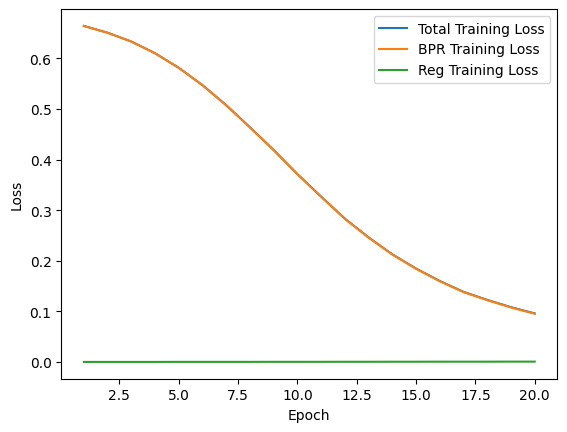

In [ ]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

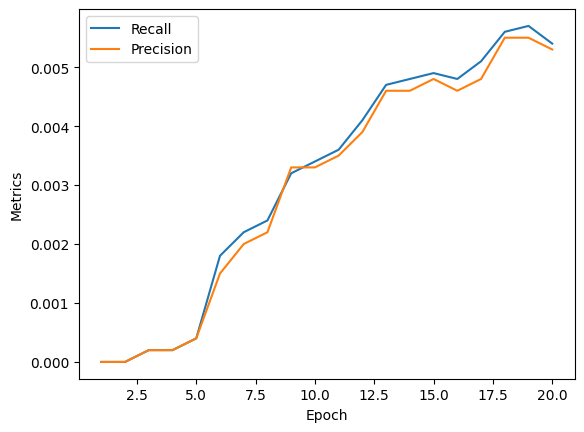

In [ ]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

# NGCF

In [ ]:
ngcf = models.RecSysGNN(
  latent_dim=parameters.LATENT_DIM,
  num_layers=parameters.N_LAYERS,
  num_users=n_users,
  num_items=n_items,
  model='NGCF'
)
ngcf.to(device)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=parameters.LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(ngcf.parameters())])

Size of Learnable Embedding :  [torch.Size([25361, 64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64])]


In [23]:
ngcf_loss, ngcf_bpr, ngcf_reg, ngcf_recall, ngcf_precision = utils.train_and_eval(ngcf, optimizer, train_df, train_edge_index, n_users, n_items, test_df, parameters.K, device)

  0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
epoch_list = [(i+1) for i in range(parameters.EPOCHS)]

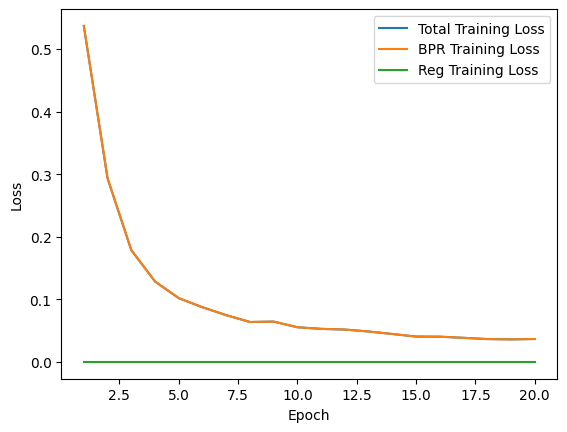

In [25]:
plt.plot(epoch_list, ngcf_loss, label='Total Training Loss')
plt.plot(epoch_list, ngcf_bpr, label='BPR Training Loss')
plt.plot(epoch_list, ngcf_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

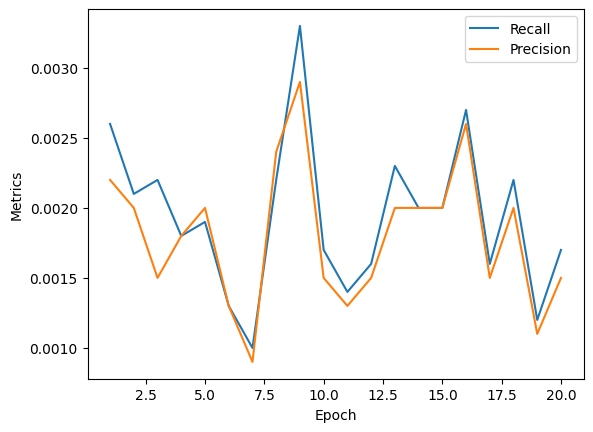

In [26]:
plt.plot(epoch_list, ngcf_recall, label='Recall')
plt.plot(epoch_list, ngcf_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

# Compare model performance

In [27]:
max(light_precision), max(light_recall)

(0.0055, 0.0057)

In [28]:
max(ngcf_precision), max(ngcf_recall)

(0.0029, 0.0033)